# Candidates

This notebook creates support material for a paper. It extracts metadata and generates figures.
It uses a list of candidates find by the iterative procedure which is described in the paper.
The list of candidates is *probably* from first run when I was experiment with the notebook.
This list is taken because the paper is prepareted in hurry and there is no to do new more
reproducible analysis and implementation.

In [1]:
import os
import numpy as np
import pandas as pd
import astropy.io.fits
import astropy.wcs
from matplotlib import pyplot as plt

In [2]:
data_file = '../data/candidates.csv'
!head $data_file

In [3]:
candidates = pd.read_csv(data_file)
candidates.head()

,path,label
0,/lamost/EG034015N073506B04/spec-56207-EG034015...,0
1,/lamost/EG034015N073506B04/spec-56207-EG034015...,0
2,/lamost/EG035637N030328B01/spec-56219-EG035637...,0
3,/lamost/EG035637N030328B01/spec-56219-EG035637...,0
4,/lamost/EG035637N030328B01/spec-56219-EG035637...,0


## Metadata

Let's extract basic metadata from FITS files.

In [5]:
def get_mag_r(header):
    magtype = header['MAGTYPE']
    try:
        return header['MAG' + str(magtype.index('r') + 1)]
    except ValueError:
        return None

In [ ]:
def extract_metadata(row):
    path, label = row
    with astropy.io.fits.open(path) as hdulist:
        header = hdulist[0].header
        filename = header['FILENAME']
        desig = header['DESIG']
        ra = header['RA']
        dec = header['DEC']
        subclass = header['SUBCLASS']
        mag_r = get_mag_r(header)
    profile = 'emission' if label == 0 else 'double-peak'
    return pd.Series(
        [filename, desig, ra, dec, subclass, mag_r, profile],
        index=['filename', 'designation', 'ra', 'dec', 'subclass', 'mag_r', 'profile']
    )

metadata = candidates.apply(extract_metadata, axis=1, result_type='expand')
metadata.head()

In [ ]:
metadata.to_csv('metadata.csv', index=False)

## Figures

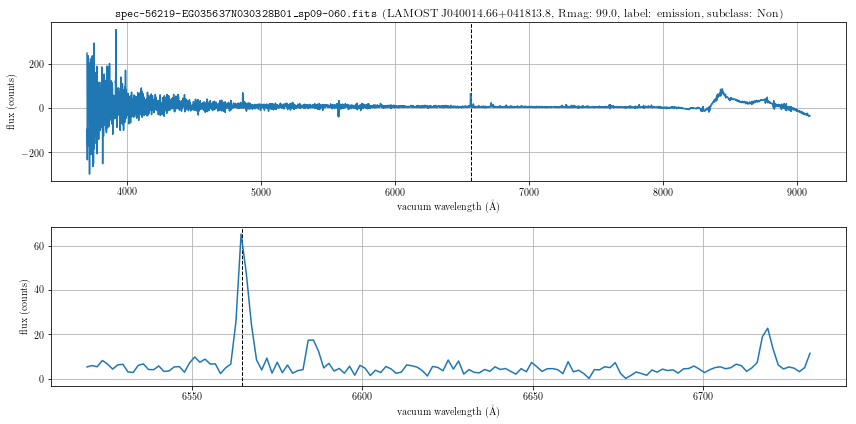

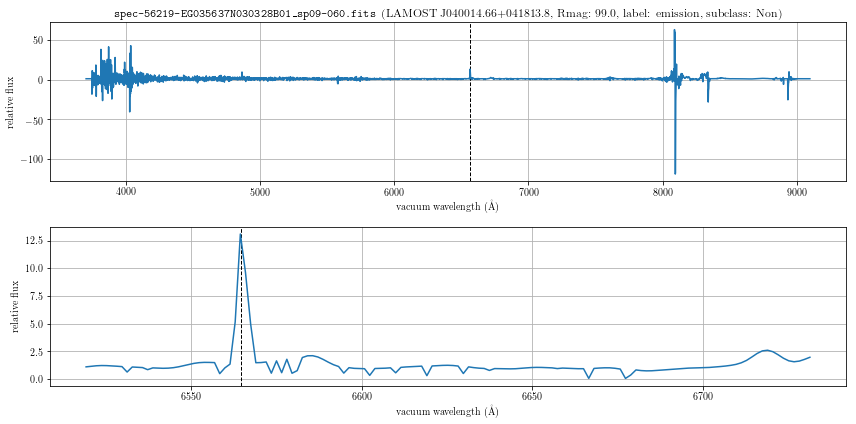

In [6]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def plot_spectrum(path, label):
    with astropy.io.fits.open(path) as hdulist:
        header = hdulist[0].header
        pixcr = np.arange(header['NAXIS1']).reshape(-1, 1)[:, [0, 0]]
        wave = 10 ** astropy.wcs.WCS(header).wcs_pix2world(pixcr, 0)[:, 0]
        flux = hdulist[0].data[0]
        subcontinuum = hdulist[0].data[2]
        desig = header['DESIG']
        mag_r = get_mag_r(header)
        filename = header['FILENAME']
        subclass = header['SUBCLASS']
    
    # plot raw data
    figsize = (12, 6)
    fig, axs = plt.subplots(nrows=2, figsize=figsize)
    safe_filename = filename.replace('_', '\_')
    title = '{{\\tt {}}} ({}, Rmag: {}, label: {}, subclass: {})'.format(
        safe_filename, desig, mag_r, 'double-peak' if label else 'emission', subclass
    )
    axs[0].set_title(title)
    for ax in axs:
        ax.set_xlabel('vacuum wavelength (\AA)')
        ax.set_ylabel('flux (counts)')
        ax.axvline(6564.614, c='black', ls='dashed', lw=1)
        ax.grid()

    axs[0].plot(wave, flux)
    h_index = (wave > 6519) & (wave < 6732)
    h_wave = wave[h_index]
    h_flux = flux[h_index]
    axs[1].plot(h_wave, h_flux)

    fig.tight_layout()
    plt.savefig('{}.pdf'.format(os.path.splitext(filename)[0]))
    
    # plot normalized data
    fig, axs = plt.subplots(nrows=2, figsize=figsize)
    axs[0].set_title(title)
    for ax in axs:
        ax.set_xlabel('vacuum wavelength (\AA)')
        ax.set_ylabel('relative flux')
        ax.axvline(6564.614, c='black', ls='dashed', lw=1)
        ax.grid()

    axs[0].plot(wave, subcontinuum)
    h_subcontinuum = subcontinuum[h_index]
    axs[1].plot(h_wave, h_subcontinuum)

    fig.tight_layout()
    plt.savefig('{}-normalized.pdf'.format(os.path.splitext(filename)[0]))

a_spectrum = candidates.iloc[2]
plot_spectrum(*a_spectrum)